In [1]:
%reload_ext autoreload
%autoreload 2

import glob
import os, gc
import numpy as numpy
import pandas as pd
import datatable as dt
import scipy as sp
from collections import defaultdict
from tqdm.notebook import tqdm
from sklearn.metrics import r2_score
from numba import njit
from utils import *

from numba_functions import *
from IPython.display import clear_output

import lightgbm as lgb

# TF
import tensorflow as tf
import tensorflow.keras.backend as K
from tensorflow.keras.callbacks import Callback, ReduceLROnPlateau, ModelCheckpoint, EarlyStopping

2021-09-19 21:31:06.568243: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcudart.so.11.0


In [2]:
N_FOLD = 5
N_MINS = 5
MIN_SIZE = 600 // N_MINS

SOL_NAME = 'Ensemble_501_601'

In [3]:
# CONSTANT
MEAN = -5.762330803300896
STD = 0.6339307835941186
EPS = 1e-9

In [4]:
list_stock_id = get_stock_id()
list_time_id = get_time_id()

In [5]:
class OptimizeRMSPE:
    def __init__(self):
        self.coef_ = 0
    
    def _rmspe(self, coef, X, y):
        # create predictions by taking row wise sum
        predictions = np.sum(X * coef, axis=1)

        # calculate auc score
        rmspe_score = rmspe(y, predictions)

        #return negative auc
        return rmspe_score
    
    def fit(self, X, y):
        from functools import partial
        loss_partial = partial(self._rmspe, X=X, y=y)
        initial_coef = np.random.dirichlet(np.ones(X.shape[1]), size=1)

        # use scipy fmin to minimize the loss function, in our case auc
        self.coef_ = sp.optimize.fmin(loss_partial, initial_coef, disp=True)

    def predict(self, X):
        predictions = np.sum(X * self.coef_, axis=1)
        return predictions

# Ensemble

In [6]:
df_result = pd.read_csv('./dataset/train.csv')
# list_result_names = ['501-lgb', '501-NN', '601-lgb', '601-NN']
list_result_names = ['501-NN', '601-lgb', '601-NN', '521-NN', '501z-NN', 'HAR_results']
for result_name in list_result_names:
    df_pred = pd.read_csv(f'./results/{result_name}.csv')
    df_pred.rename(columns={'pred': f'pred_{result_name}'}, inplace=True)
    df_result = df_result.merge(df_pred[['stock_id', 'time_id', f'pred_{result_name}']], on=['stock_id', 'time_id'], how='inner', validate='one_to_one')
print(df_result.isna().any().any())
df_result.head()

False


,stock_id,time_id,target,pred_501-NN,pred_601-lgb,pred_601-NN,pred_521-NN,pred_501z-NN,pred_HAR_results
0,0,5,0.004136,0.003920,0.003944,0.003682,0.004054,0.003916,0.003843
1,0,11,0.001445,0.001681,0.001515,0.001462,0.001513,0.001680,0.001540
2,0,16,0.002168,0.002411,0.002284,0.002416,0.002464,0.002365,0.002068
3,0,31,0.002195,0.002197,0.001944,0.001986,0.002179,0.002380,0.002021
4,0,62,0.001747,0.001463,0.001743,0.001687,0.001684,0.001680,0.001765


In [19]:
pred_cols = [f'pred_{c}' for c in list_result_names]
rmspes = np.vstack([df_result.groupby('stock_id').apply(lambda x: rmspe(x['target'], x[c])) for c in pred_cols]).T
best_idx = np.argmin(rmspes, axis=1)

In [23]:
for i, stock_id in enumerate(list_stock_id):
    idx = best_idx[i]
    df_result.loc[df_result['stock_id']==stock_id, 'pred'] = df_result.loc[df_result['stock_id']==stock_id, pred_cols[idx]]

In [25]:
rmspe(df_result['target'], df_result['pred'])

0.209942483881843

In [ ]:
hist = dict{(20, 30): 3, (30, 40): 5}

In [39]:
hist = {(20, 30): 3, (30, 40): 5}
lower, upper = 20, 40
hist_mids = list(map(lambda x: .5*(x[0] + x[1]), hist.keys()))
lower_mid = min([m for m in hist_mids if m > lower]) # > or >= ?
upper_mid = max([m for m in hist_mids if m < upper])
highlighted_bins = [k for k in hist.keys() if lower_mid <= .5*(k[0]+k[1]) <= upper_mid] # < or <=?
lower_highlighted = min([k[0] for k in highlighted_bins])
upper_highlighted = max([k[1] for k in highlighted_bins])

In [40]:
highlighted_bins

[(20, 30), (30, 40)]

In [41]:
def get_rec_salary_range(midpoints, x_percentile, hist):
    lower, median, upper = rec_range_median(
        midpoints,
        x_percentile
    )
    lower_mid = min([mid for mid in hist_mids if lower <= mid]) # < or <= ?
    upper_mid = max([mid for mid in hist_mids if mid < upper])
    highlighted_bins = [k for k in hist.keys() if lower_mid <= .5*(k[0]+k[1]) <= upper_mid]
    lower_highlighted = min([k[0] for k in highlighted_bins])
    upper_highlighted = max([k[1] for k in highlighted_bins])
    return lower_highlighted, upper_highlighted
    

In [11]:
rmspe(df_result.target, df_result[['pred_501-NN', 'pred_HAR_results']].min(axis=1))

0.22711883790515136

In [12]:
rmspe(df_result.target, df_result[['pred_501-NN', 'pred_HAR_results']].max(axis=1))

0.2227746064897726

In [7]:
df_rmspe = pd.DataFrame(columns=list_result_names)
for col in list_result_names:
    df_rmspe[col] = df_result.groupby('stock_id').apply(lambda x: rmspe(x['target'], x[f'pred_{col}']))

In [8]:
df_rmspe = pd.DataFrame(columns=list_result_names)
for col in list_result_names:
    df_rmspe[col] = df_result.groupby('time_id').apply(lambda x: rmspe(x['target'], x[f'pred_{col}']))

In [13]:
df_result.loc[df_result.stock_id==31].sort_values('target').head(10)

,stock_id,time_id,target,pred_501-NN,pred_601-lgb,pred_601-NN,pred_521-NN,pred_501z-NN,pred_HAR_results
108254,31,8534,0.000105,0.000581,0.001029,0.000703,0.000336,0.000678,0.001796
107548,31,2479,0.000109,0.000338,0.001133,0.000699,0.000187,0.000262,0.000677
107832,31,4867,0.000113,0.000292,0.000423,0.000238,0.000260,0.000170,0.000002
110479,31,27174,0.000123,0.000963,0.000982,0.000987,0.000561,0.000905,0.000908
107743,31,4142,0.000137,0.000394,0.000572,0.000443,0.000174,0.000266,0.000713
110278,31,25504,0.000139,0.002190,0.002525,0.002073,0.001575,0.002346,0.002258
110453,31,26997,0.000145,0.000347,0.001089,0.000211,0.000163,0.000198,0.000325
109234,31,16601,0.000155,0.000419,0.000847,0.000425,0.000279,0.000400,0.000628
107539,31,2436,0.000164,0.000364,0.000568,0.000539,0.000244,0.000360,0.000409
108638,31,11844,0.000175,0.000685,0.001109,0.000486,0.000301,0.000585,0.000835


In [16]:
a = (df_result['pred_501-NN'] - df_result['target']).abs()
b = (df_result['pred_HAR_results'] - df_result['target']).abs()
df_result['pred_'] = df_result['pred_501-NN'] *(a<b) + df_result['pred_HAR_results'] *(a>=b)

In [17]:
rmspe(df_result['target'], df_result['pred_'])

0.1868883709395331

In [22]:
df_result['label'] = a<b

In [24]:
df_result[['stock_id', 'time_id', 'label']].to_csv('label_.csv', index=False)

In [20]:
sum(a<b)

246960

In [21]:
sum(a>b)

181972

[Text(0.5, 0, 'rmspe')]

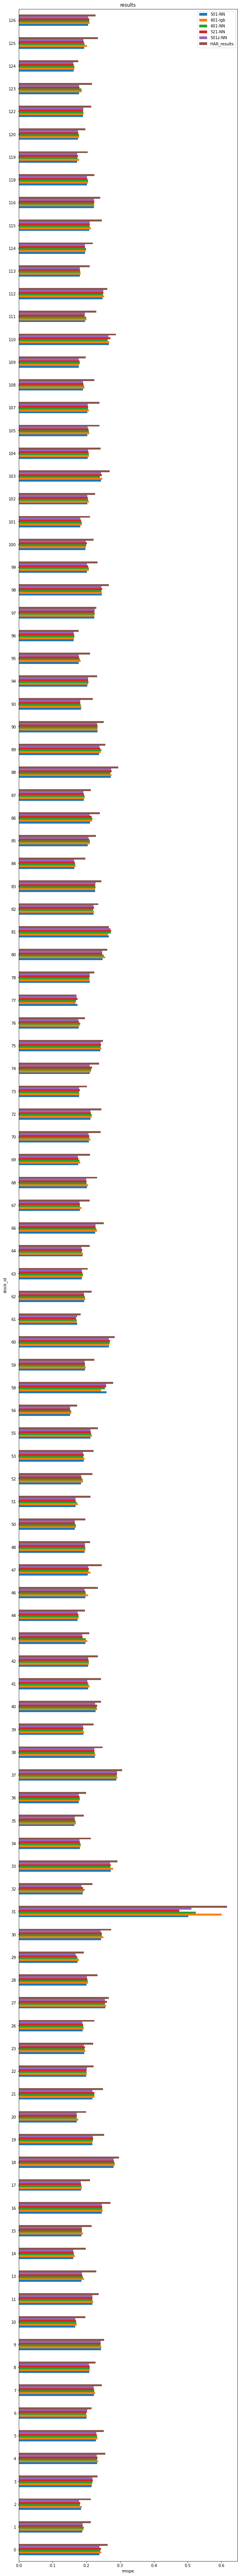

In [29]:
import matplotlib.pyplot as plt
ax = df_rmspe.plot(kind='barh', ylabel='stock_id', title='results', figsize=(10, 120))
ax.set(xlabel='rmspe')

In [35]:
# blend with weights
# blend_result_names = ['501-lgb', '501-NN', '601-lgb', '601-NN']
# blend_result_names = ['501-NN', '601-lgb', '601-NN', '521-NN']
blend_result_names = list_result_names
pred_cols = [f'pred_{result_name}' for result_name in blend_result_names]
opt = OptimizeRMSPE()
df_result['bias'] = 1
opt.fit(df_result[pred_cols].values, df_result['target'].values)
print(opt.coef_)

df_result['pred_opt'] = np.sum(opt.coef_ * df_result[pred_cols], axis=1)
rmspe(df_result.target, df_result.pred_opt)

Optimization terminated successfully.
         Current function value: 0.207679
         Iterations: 397
         Function evaluations: 625
[ 0.18667159  0.19851909  0.20975358  0.23525411  0.18872339 -0.02344906]


0.20767897306316235

In [36]:
# harmonic mean
rmspe(df_result.target, sp.stats.hmean(df_result[pred_cols].values, axis=1))

0.20883624182755509

In [37]:
# decision tree
from sklearn.tree import DecisionTreeRegressor

blend_model = DecisionTreeRegressor(max_depth=18)
blend_model.fit(df_result[pred_cols], df_result.target)
rmspe(df_result.target, blend_model.predict(df_result[pred_cols]))

0.19723591270872334

In [40]:
save_pickle(blend_model, 'blend_model.pkl')

Done!
